In [ ]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

from keras import models
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop,Adam
from keras.utils import to_categorical



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
data = pd.read_csv('/content/drive/MyDrive/Major 7th sem(Emotion Detection)/icml_face_data.csv')
data.head()


,emotion,Usage,pixels
0,0,Training,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1,0,Training,151 150 147 155 148 133 111 140 170 174 182 15...
2,2,Training,231 212 156 164 174 138 161 173 182 200 106 38...
3,4,Training,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4,6,Training,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...


In [ ]:
train_data = pd.read_csv('/content/drive/MyDrive/Major 7th sem(Emotion Detection)/train.csv')
print(train_data)
test_data = pd.read_csv('/content/drive/MyDrive/Major 7th sem(Emotion Detection)/test.csv')
print(test_data)

       emotion                                             pixels
0            0  70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1            0  151 150 147 155 148 133 111 140 170 174 182 15...
2            2  231 212 156 164 174 138 161 173 182 200 106 38...
3            4  24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4            6  4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...
...        ...                                                ...
28704        2  84 85 85 85 85 85 85 85 86 86 86 87 86 86 91 9...
28705        0  114 112 113 113 111 111 112 113 115 113 114 11...
28706        4  74 81 87 89 95 100 98 93 105 120 127 133 146 1...
28707        0  222 227 203 90 86 90 84 77 94 87 99 119 134 14...
28708        4  195 199 205 206 205 203 206 209 208 210 212 21...

[28709 rows x 2 columns]
                                                 pixels
0     254 254 254 254 254 249 255 160 2 58 53 70 77 ...
1     156 184 198 202 204 207 210 212 213 214 215 21...
2     69 118 6

In [ ]:
def prepare_data(data):
    """ Prepare data for modeling 
        input: data frame with labels und pixel data
        output: image and label array """
    
    image_array = np.zeros(shape=(len(data), 48, 48))
    image_label = np.array(list(map(int, data['emotion'])))
    
    for i, row in enumerate(data.index):
        image = np.fromstring(data.loc[row, ' pixels'], dtype=int, sep=' ')
        image = np.reshape(image, (48, 48))
        image_array[i] = image
        
    return image_array, image_label

def plot_examples(label=0):
    fig, axs = plt.subplots(1, 5, figsize=(25, 12))
    fig.subplots_adjust(hspace = .2, wspace=.2)
    axs = axs.ravel()
    for i in range(5):
        idx = data[data['emotion']==label].index[i]
        axs[i].imshow(train_images[idx][:,:,0], cmap='gray')
        axs[i].set_title(emotions[train_labels[idx].argmax()])
        axs[i].set_xticklabels([])
        axs[i].set_yticklabels([])

def plot_all_emotions():
    fig, axs = plt.subplots(1, 7, figsize=(30, 12))
    fig.subplots_adjust(hspace = .2, wspace=.2)
    axs = axs.ravel()
    for i in range(7):
        idx = data[data['emotion']==i].index[i]
        axs[i].imshow(train_images[idx][:,:,0], cmap='gray')
        axs[i].set_title(emotions[train_labels[idx].argmax()])
        axs[i].set_xticklabels([])
        axs[i].set_yticklabels([])

def plot_image_and_emotion(test_image_array, test_image_label, pred_test_labels, image_number):
    """ Function to plot the image and compare the prediction results with the label """
    
    fig, axs = plt.subplots(1, 2, figsize=(12, 6), sharey=False)
    
    bar_label = emotions.values()
    
    axs[0].imshow(test_image_array[image_number], 'gray')
    axs[0].set_title(emotions[test_image_label[image_number]])
    
    axs[1].bar(bar_label, pred_test_labels[image_number])
    axs[1].grid()
    
    plt.show()

def plot_compare_distributions(array1, array2, title1='', title2=''):
    df_array1 = pd.DataFrame()
    df_array2 = pd.DataFrame()
    df_array1['emotion'] = array1.argmax(axis=1)
    df_array2['emotion'] = array2.argmax(axis=1)
    
    fig, axs = plt.subplots(1, 2, figsize=(12, 6), sharey=False)
    x = emotions.values()
    
    y = df_array1['emotion'].value_counts()
    keys_missed = list(set(emotions.keys()).difference(set(y.keys())))
    for key_missed in keys_missed:
        y[key_missed] = 0
    axs[0].bar(x, y.sort_index())
    axs[0].set_title(title1)
    axs[0].grid()
    
    y = df_array2['emotion'].value_counts()
    keys_missed = list(set(emotions.keys()).difference(set(y.keys())))
    for key_missed in keys_missed:
        y[key_missed] = 0
    axs[1].bar(x, y.sort_index())
    axs[1].set_title(title2)
    axs[1].grid()
    
    plt.show()



In [ ]:
data[' Usage'].value_counts()

Training       28709
PublicTest      3589
PrivateTest     3589
Name:  Usage, dtype: int64

In [ ]:
emotions = {0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}

In [ ]:
train_image_array, train_image_label = prepare_data(data[data[' Usage']=='Training'])
val_image_array, val_image_label = prepare_data(data[data[' Usage']=='PrivateTest'])
test_image_array, test_image_label = prepare_data(data[data[' Usage']=='PublicTest'])

In [ ]:
train_images = train_image_array.reshape((train_image_array.shape[0], 48, 48, 1))
train_images = train_images.astype('float32')/255
val_images = val_image_array.reshape((val_image_array.shape[0], 48, 48, 1))
val_images = val_images.astype('float32')/255
test_images = test_image_array.reshape((test_image_array.shape[0], 48, 48, 1))
test_images = test_images.astype('float32')/255

In [ ]:
train_labels = to_categorical(train_image_label)
val_labels = to_categorical(val_image_label)
test_labels = to_categorical(test_image_label)

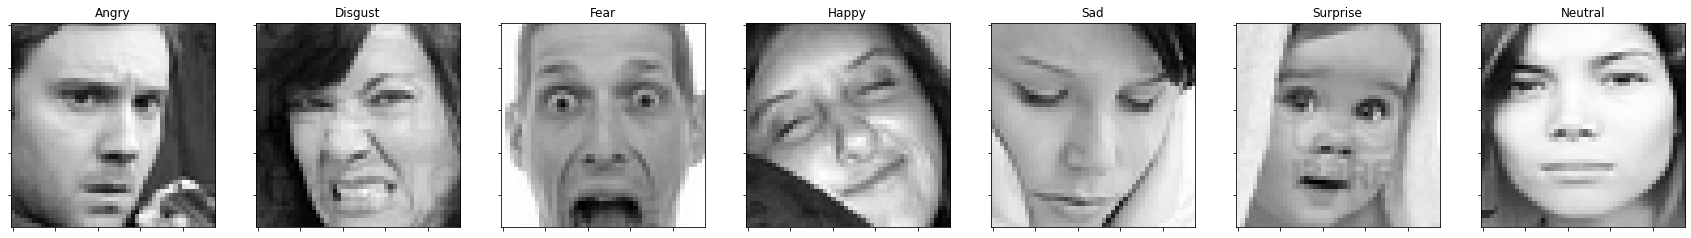

In [ ]:
plot_all_emotions()

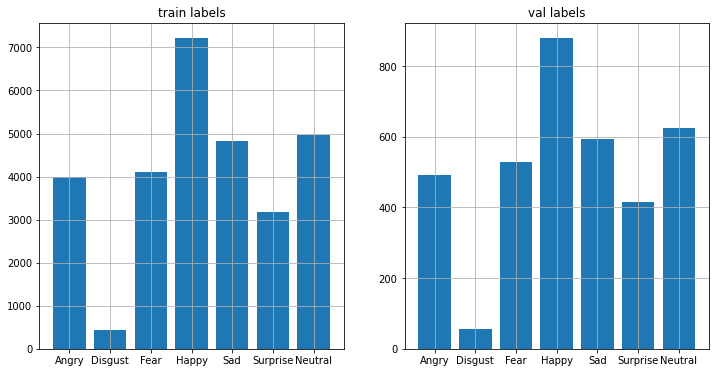

In [ ]:
plot_compare_distributions(train_labels, val_labels, title1='train labels', title2='val labels')

In [ ]:
class_weight = dict(zip(range(0, 7), (((data[data[' Usage']=='Training']['emotion'].value_counts()).sort_index())/len(data[data[' Usage']=='Training']['emotion'])).tolist()))

class_weight



{0: 0.1391549688251071,
 1: 0.01518687519593159,
 2: 0.14270786164617366,
 3: 0.2513149186666202,
 4: 0.16823992476226968,
 5: 0.11045316799609878,
 6: 0.17294228290779895}

In [ ]:
model = models.Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(48, 48, 1)))
model.add(MaxPool2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPool2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(7, activation='softmax'))

model.compile(optimizer=Adam(lr=1e-3), loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()



Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 46, 46, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 23, 23, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 21, 21, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 10, 10, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 64)          36928     
_________________________________________________________________
flatten (Flatten)            (None, 4096)              0         
_________________________________________________________________
dense (Dense)                (None, 64)                2

In [ ]:
history = model.fit(train_images, train_labels,
                    validation_data=(val_images, val_labels),
                    class_weight = class_weight,
                    epochs=12,
                    batch_size=64)

Epoch 1/12
449/449 [==============================] - 75s 165ms/step - loss: 0.2798 - accuracy: 0.2862 - val_loss: 1.5782 - val_accuracy: 0.4202
Epoch 2/12
449/449 [==============================] - 74s 165ms/step - loss: 0.2256 - accuracy: 0.4426 - val_loss: 1.4120 - val_accuracy: 0.4765
Epoch 3/12
449/449 [==============================] - 77s 171ms/step - loss: 0.2045 - accuracy: 0.5003 - val_loss: 1.3321 - val_accuracy: 0.4999
Epoch 4/12
449/449 [==============================] - 74s 165ms/step - loss: 0.1935 - accuracy: 0.5233 - val_loss: 1.2939 - val_accuracy: 0.5166
Epoch 5/12
449/449 [==============================] - 75s 167ms/step - loss: 0.1827 - accuracy: 0.5526 - val_loss: 1.2681 - val_accuracy: 0.5288
Epoch 6/12
449/449 [==============================] - 74s 165ms/step - loss: 0.1717 - accuracy: 0.5789 - val_loss: 1.2419 - val_accuracy: 0.5375
Epoch 7/12
449/449 [==============================] - 74s 165ms/step - loss: 0.1634 - accuracy: 0.6031 - val_loss: 1.2476 - val_ac

In [ ]:
test_loss, test_acc = model.evaluate(test_images, test_labels)
print('test accuracy:', test_acc)

113/113 [==============================] - 3s 25ms/step - loss: 1.3797 - accuracy: 0.5350
test caccuracy: 0.5349679589271545


In [ ]:
pred_test_labels = model.predict(test_images)
test_images.shape

(3589, 48, 48, 1)

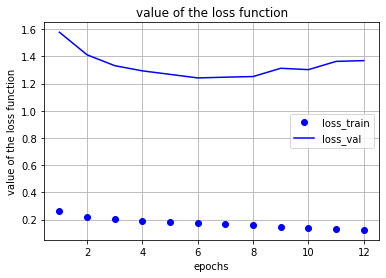

In [ ]:
loss = history.history['loss']
loss_val = history.history['val_loss']
epochs = range(1, len(loss)+1)
plt.plot(epochs, loss, 'bo', label='loss_train')
plt.plot(epochs, loss_val, 'b', label='loss_val')
plt.title('value of the loss function')
plt.xlabel('epochs')
plt.ylabel('value of the loss function')
plt.legend()
plt.grid()
plt.show()


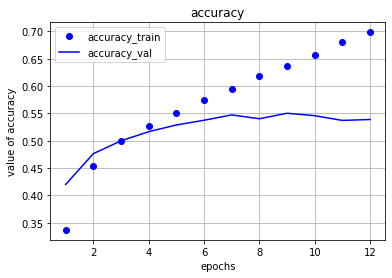

In [ ]:
acc = history.history['accuracy']
acc_val = history.history['val_accuracy']
epochs = range(1, len(loss)+1)
plt.plot(epochs, acc, 'bo', label='accuracy_train')
plt.plot(epochs, acc_val, 'b', label='accuracy_val')
plt.title('accuracy')
plt.xlabel('epochs')
plt.ylabel('value of accuracy')
plt.legend()
plt.grid()
plt.show()

In [ ]:
model_json = model.to_json()
with open("model.json", "w") as json_file:
  json_file.write(model_json)
  model.save_weights("model.h5")
print("Saved model to disk")


Saved model to disk


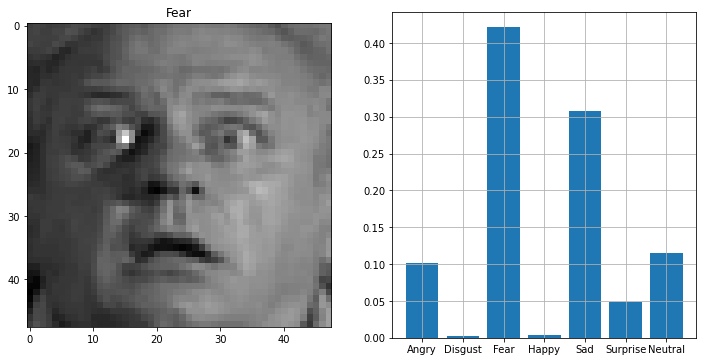

In [ ]:
plot_image_and_emotion(test_image_array, test_image_label, pred_test_labels, 1000)



In [ ]:
df_compare = pd.DataFrame()
df_compare['real'] = test_labels.argmax(axis=1)
df_compare['pred'] = pred_test_labels.argmax(axis=1)
df_compare['wrong'] = np.where(df_compare['real']!=df_compare['pred'], 1, 0)

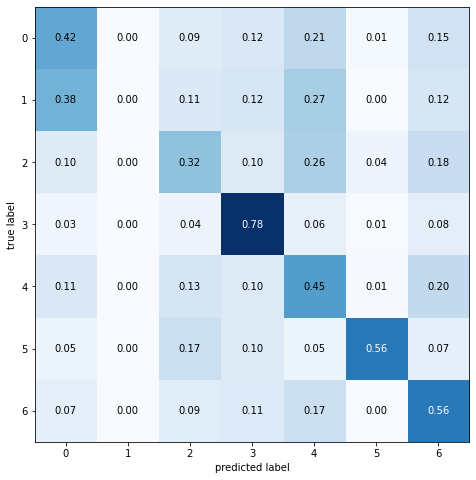

In [ ]:
conf_mat = confusion_matrix(test_labels.argmax(axis=1), pred_test_labels.argmax(axis=1))

fig, ax = plot_confusion_matrix(conf_mat=conf_mat,
                                show_normed=True,
                                show_absolute=False,
                                figsize=(8, 8))
fig.show()

In [ ]:
import cv2
from keras.models import model_from_json
from keras.preprocessing import image

In [ ]:
model = model_from_json(open("model.json", "r").read())
model.load_weights('model.h5')
face_haar_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

In [ ]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

<IPython.core.display.Javascript object>

Saved to photo.jpg


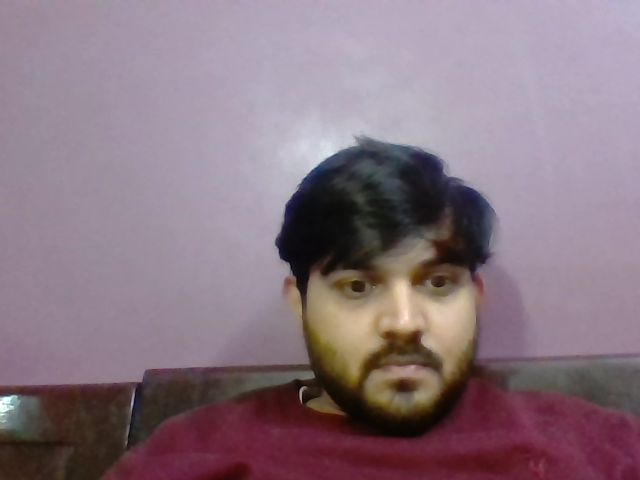

In [ ]:
from IPython.display import Image
try:
  filename = take_photo()
  print('Saved to {}'.format(filename))
  
  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

In [ ]:
img = cv2.imread('/content/photo.jpg') 

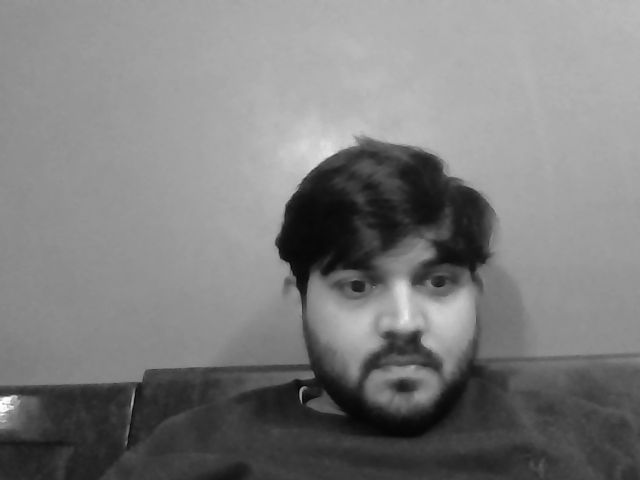

In [ ]:
from google.colab.patches import cv2_imshow # for image display
gray_image= cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
cv2_imshow(gray_image)

In [ ]:
faces_detected = face_haar_cascade.detectMultiScale(gray_image)
faces_detected

array([[294, 206, 212, 212]], dtype=int32)

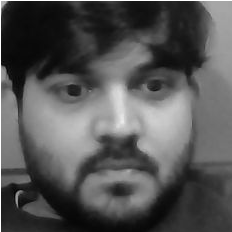

In [ ]:
for (x,y,w,h) in faces_detected:
  cv2.rectangle(gray_image,(x-10,y-10), (x+w+10,y+h+10), (255,0,0))
  roi_gray=gray_image[y-10:y+w+10,x-10:x+h+10]
cv2_imshow(roi_gray)

In [ ]:
from keras.preprocessing.image import img_to_array
roi = cv2.resize(roi_gray, (48, 48))
roi = roi.astype("float") / 255.0
roi = img_to_array(roi)
roi = np.expand_dims(roi, axis=0)
roi.shape

(1, 48, 48, 1)

In [ ]:
predictions = model.predict(roi)[0]
print(predictions)
max_index = np.argmax(predictions)
emotion_detection = ('angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral')
emotion_prediction = emotion_detection[max_index]
print(emotion_prediction)


[0.04794213 0.00133595 0.05549757 0.00174829 0.13196684 0.04456902
 0.71694016]
neutral


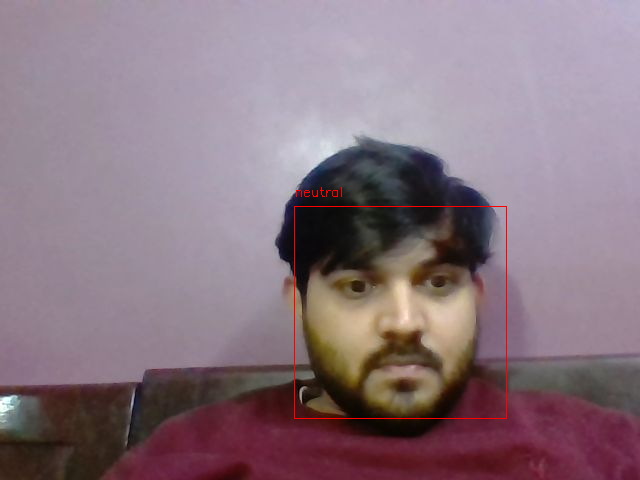

In [ ]:
cv2.putText(img,emotion_prediction, (x, y - 10),cv2.FONT_HERSHEY_SIMPLEX, 0.45, (0, 0, 255), 1)
cv2.rectangle(img, (x, y), (x + w, y + h),(0, 0, 255), 1)
cv2_imshow(img)